In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pandas as pd
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

In [3]:
# Load csv
df = pd.read_csv("players_data.csv")
print(df.head())

   userNum nickname    gameId  seasonId  gameRank character            weapon  \
0  5426009       마샤  46678118        31         2     Cathy            Dagger   
1  5296453   쿠로미여동생  46678118        31         1     Hisui  Two-handed_Sword   
2  5162955   우주생명마음  46678118        31         5     Adina            Arcana   
3  5140049  只玩过卡拉彼丘  46678118        31         7    Ly Anh            Dagger   
4  5051669  초고교급마다키  46678118        31         7   Tsubame          Shuriken   

         itemWeapon     itemChest        itemHead  ...            Trait_Main1  \
0             Asura  The_Revenant  Imperial_Crown  ...   Unwavering_Mentality   
1  Aurora_Longsword        Áo_Dài  Blaster_Helmet  ...  Contempt_for_the_Weak   
2          The_Moon   Blood_Cloak         Persona  ...            Open_Wounds   
3          Maharaja  Dragon_Dobok      Cowboy_Hat  ...                 Frenzy   
4     Petal_Torrent      Changpao   Crystal_Tiara  ...      Dismantle_Goliath   

    Trait_Main2           

In [4]:
# Drop rows with missing values in key features
df = df.dropna(subset=[
    'character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead',
    'itemArm', 'itemLeg', 'Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2',
    'TeamKill', 'Kill', 'Death', 'Assist', 'Dmg_Player', 'Dmg_Monster', 'gameRank'
])

In [5]:
# Features and target
features = [
    'character', 'weapon', 'itemWeapon', 'itemChest', 'itemHead',
    'itemArm', 'itemLeg', 'Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2',
    'TeamKill', 'Kill', 'Death', 'Assist', 'Dmg_Player', 'Dmg_Monster'
]
target = 'gameRank'

X = df[features]
y = df[target]

In [6]:
# Identify categorical and numerical columns
Categorical = X.select_dtypes(include='object').columns.tolist()
Numeric = [col for col in X.columns if col not in Categorical]

In [7]:
# Preprocessor: Ordinal encode categoricals, passthrough numericals
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), Categorical),
        ('num', 'passthrough', Numeric)
    ]
)

In [ ]:
# Complete pipeline
CharWin_Pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', HistGradientBoostingRegressor(max_iter=100, random_state=42))
])

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#lighter multi model tester
# Sample and prepare dataset
SAMPLE_SIZE = 8000
train_df = X_train.copy()
train_df['label'] = y_train  # no need to encode for regression

sampled_df = train_df.sample(n=SAMPLE_SIZE, random_state=42)
X_sampled = sampled_df.drop(columns='label')
y_sampled = sampled_df['label'].values

# Define regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_jobs=-1, random_state=42),
    "LightGBM": LGBMRegressor(n_jobs=-1, random_state=42)
}

from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# Define scoring metrics
regression_metrics = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mape': 'neg_mean_absolute_percentage_error'
}

results = {}

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name}...")

    # Hyperparameter tuning if needed
    if name == "Random Forest":
        param_dist = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
        model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)

    if name == "Gradient Boosting":
        param_dist = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
        model = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,
        scoring=list(regression_metrics.values()),
        return_train_score=False,
        n_jobs=-1,
        verbose=10
    )

    # Store results
    results[name] = {
        'r2': (scores['test_r2'].mean(), scores['test_r2'].std()),
        'rmse': (-scores['test_neg_root_mean_squared_error'].mean(), scores['test_neg_root_mean_squared_error'].std()),
        'mae': (-scores['test_neg_mean_absolute_error'].mean(), scores['test_neg_mean_absolute_error'].std()),
        'mape': (-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std())
    }

# Format as DataFrame
results_df = pd.DataFrame(results).T

# Expand columns
for metric in regression_metrics.keys():
    results_df[[f'{metric}_mean', f'{metric}_std']] = pd.DataFrame(results_df[metric].tolist(), index=results_df.index)

results_df = results_df.drop(columns=regression_metrics.keys())
results_df = results_df.sort_values(by='r2_mean', ascending=False)

# Show results
print(results_df)


Evaluating Linear Regression...
Evaluating Ridge...
Evaluating Lasso...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07826399803161621s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07478713989257812s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08628606796264648s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07549262046813965s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using

Evaluating ElasticNet...
Evaluating Decision Tree...


[Parallel(n_jobs=-1)]: Batch computation too fast (0.14281964302062988s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating Random Forest...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating Gradient Boosting...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   48.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating HistGradientBoosting...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating AdaBoost...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating Extra Trees...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating XGBoost...


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Evaluating LightGBM...
                       r2_mean    r2_std  rmse_mean  rmse_std  mae_mean  \
HistGradientBoosting  0.680878  0.002448   1.261386  0.008597  0.983253   
LightGBM              0.678708  0.003329   1.265657  0.009391  0.987930   
Gradient Boosting     0.678383  0.002295   1.266307  0.008319  0.994709   
Random Forest         0.655802  0.002500   1.309979  0.000944  1.027365   
Extra Trees           0.653028  0.002654   1.315247  0.002490  1.031526   
XGBoost               0.643438  0.001977   1.333328  0.007677  1.038078   
Ridge                 0.577441  0.005318   1.451481  0.013659  1.167168   
Linear Regression     0.577441  0.005318   1.451481  0.013659  1.167168   
ElasticNet            0.576199  0.005806   1.453610  0.014441  1.169374   
Lasso                 0.573963  0.005716   1.457440  0.014305  1.173107   
AdaBoost              0.549328  0.004818   1.498941  0.003006  1.258051   
Decision Tree         0.285674  0.017780   1.886976  0.017896  1.393248   

 

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


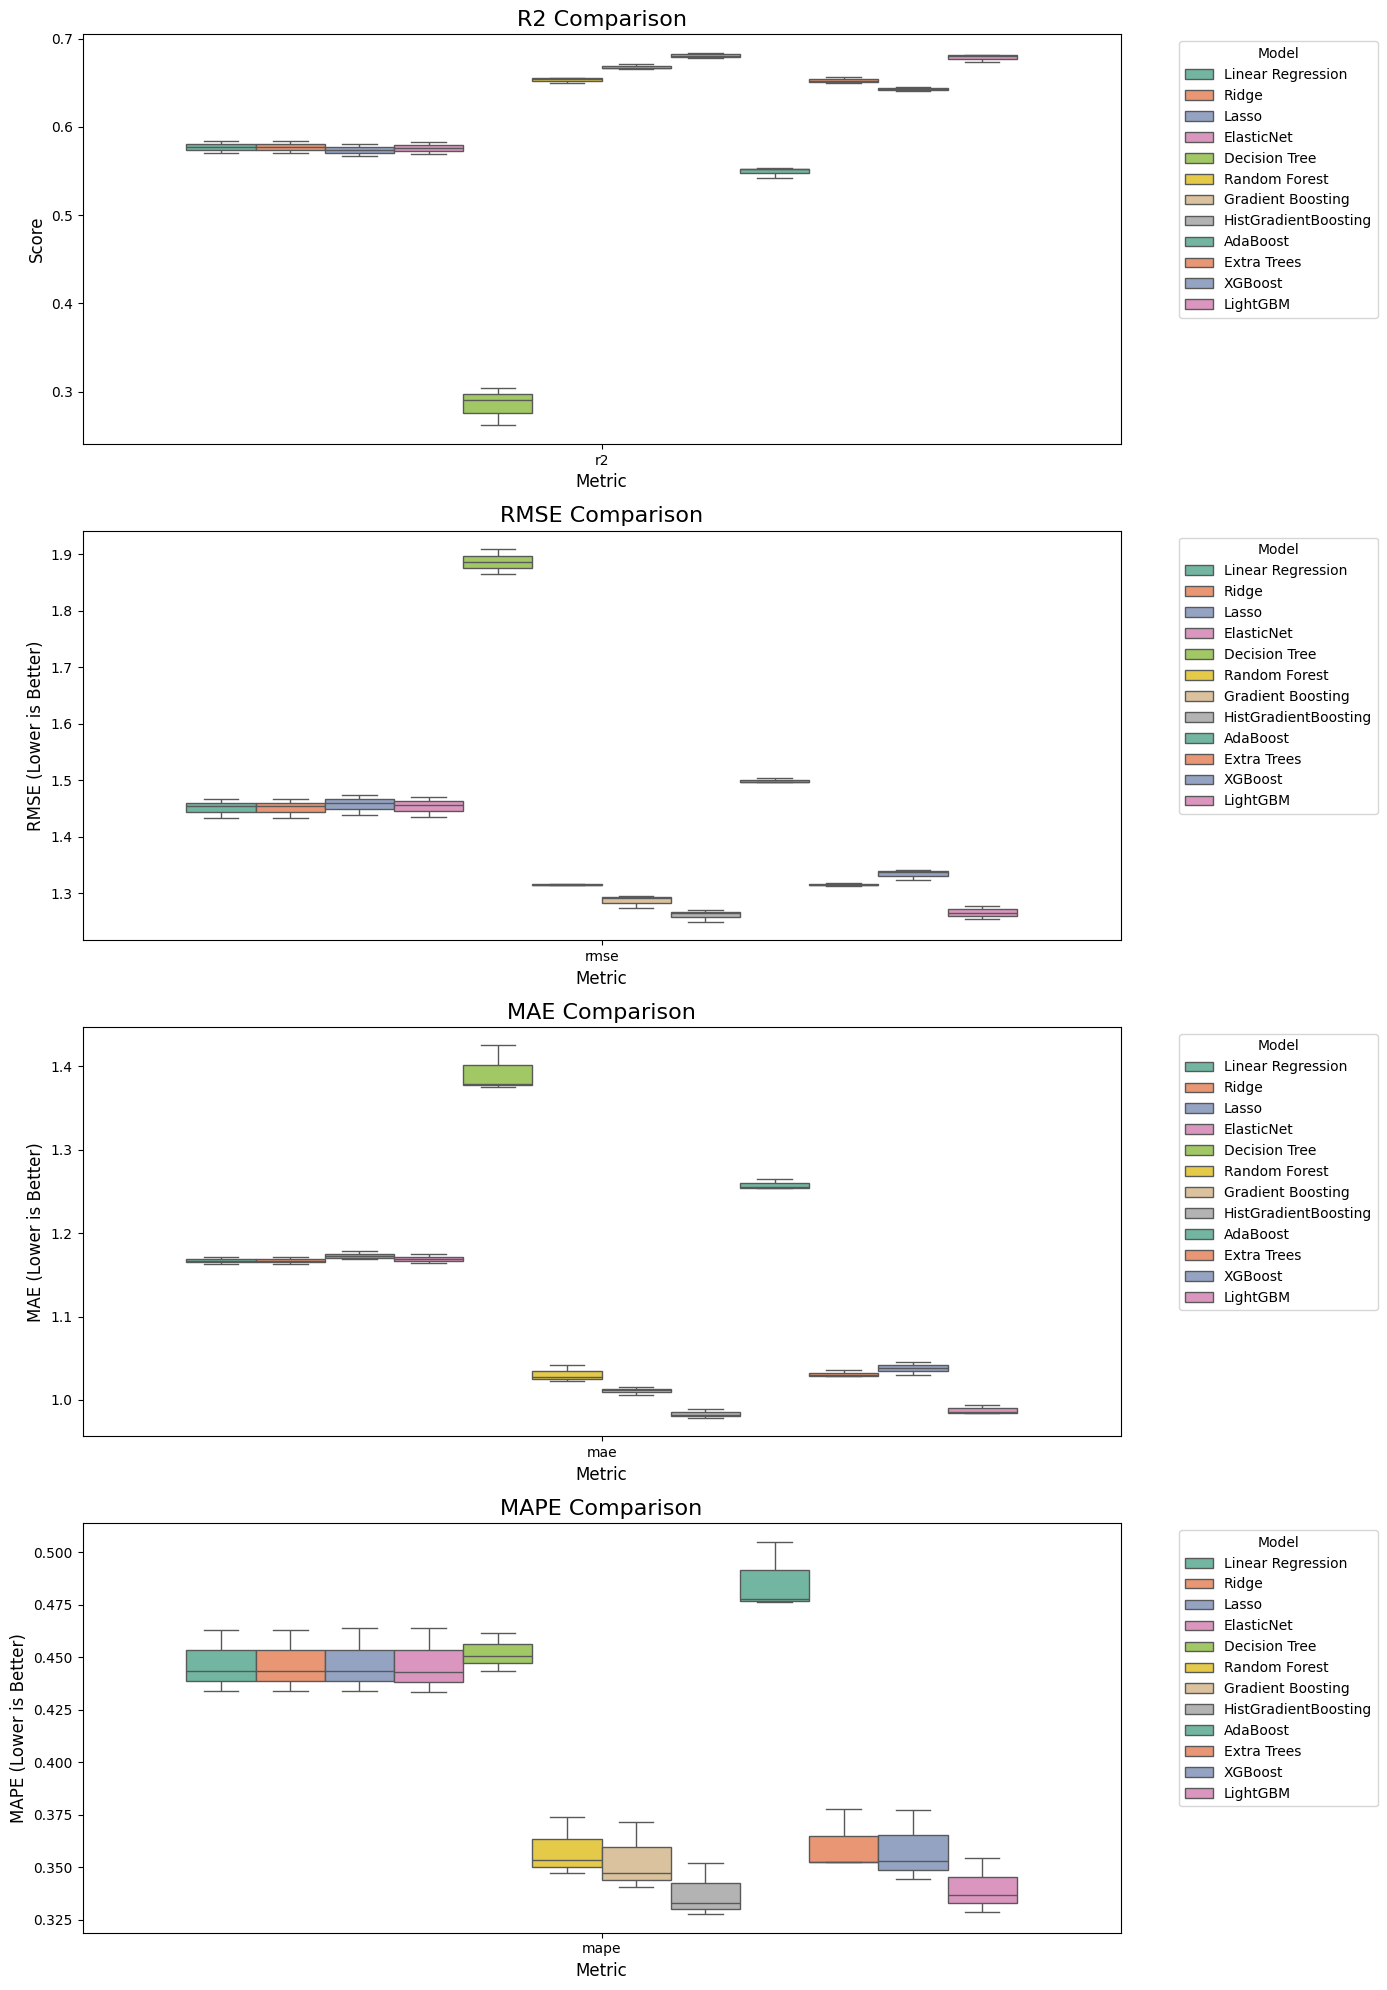

In [ ]:
cv_results = {
    'model': [],
    'metric': [],
    'score': []
}

# Metric labels
metric_labels = {
    'r2': 'r2',
    'neg_root_mean_squared_error': 'rmse',
    'neg_mean_absolute_error': 'mae',
    'neg_mean_absolute_percentage_error': 'mape'
}

# Evaluate each model
for name, model in models.items():
    print(f"Evaluating {name} (for box)...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,
        scoring=list(metric_labels.keys()),
        return_train_score=False,
        n_jobs=-1
    )

    for metric, label in metric_labels.items():
        for score in scores[f'test_{metric}']:
            score_val = -score if metric.startswith('neg_') else score
            cv_results['model'].append(name)
            cv_results['metric'].append(label)
            cv_results['score'].append(score_val)

# Only now: convert to DataFrame and plot
cv_results_df = pd.DataFrame(cv_results)

# Plot
plt.figure(figsize=(14, 5 * len(metric_labels)))

for i, metric in enumerate(metric_labels.values(), 1):
    plt.subplot(len(metric_labels), 1, i)
    sns.boxplot(
        x='metric',
        y='score',
        hue='model',
        data=cv_results_df[cv_results_df['metric'] == metric],
        palette='Set2'
    )
    plt.title(f'{metric.upper()} Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    if metric != 'r2':
        plt.ylabel(f'{metric.upper()} (Lower is Better)')

plt.tight_layout()
plt.show()


In [ ]:
#fit the model
CharWin_Pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['character', 'weapon',
                                                   'itemWeapon', 'itemChest',
                                                   'itemHead', 'itemArm',
                                                   'itemLeg', 'Trait_Main1',
                                                   'Trait_Main2', 'Trait_Sub1',
                                                   'Trait_Sub2']),
                                                 ('num', 'passthrough',
                                                  ['TeamKill', 'Kill', 'Death',
                                                   'Assist', 'Dmg_Player',
                                                   'Dmg_Monster'])])),
                ('regressor', HistGradientBoostingRegressor(random_state=42))])

In [ ]:
#Score
y_pred = CharWin_Pipeline.predict(X_test)
print("R² Score:", round(r2_score(y_test, y_pred), 4))
print("RMSE:", round(mean_squared_error(y_test, y_pred, squared=False), 4))

R² Score: 0.7135
RMSE: 1.196


c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
def TestCode(character_name, games=50):
    chara = df[df['character'] == character_name]
    if chara.empty:
        return f"No data available for character: {character_name}"

    #Past Data in csv
    Avg_Rank = chara['gameRank'].mean()
    Past_Win_Rate = (chara['gameRank'] <= 3).mean()

    #Features
    X_char = chara[features].copy()
    y_pred = CharWin_Pipeline.predict(X_char)
    pred_win_rate = (y_pred <= 3).mean()
    projected_wins = int(pred_win_rate * games)

    return {
        "Character": character_name,
        "Historical AverageRank": round(Avg_Rank, 2),
        "Historical Win Rate (%)": round(Past_Win_Rate * 100, 2),
        "Predicted Win Rate (%)": round(pred_win_rate * 100, 2),
        "Projected Wins In Next 50 Games": projected_wins
    }

In [35]:
# Example usage
from pprint import pprint
result = TestCode("Cathy")
pprint(result)

{'Character': 'Cathy',
 'Historical AverageRank': 4.3,
 'Historical Win Rate (%)': 39.89,
 'Predicted Win Rate (%)': 25.95,
 'Projected Wins In Next 50 Games': 12}
